In [78]:
import sys
from scipy.constants import c,pi
import numpy as np
from math import factorial
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.constants import c
import warnings 
warnings.filterwarnings('ignore')

In [79]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

### Entry 27/1/2016
Have taken a break from this so that to write a presentation for the CDT. Will have to take another break because of the poster the CDT is asking me to do.

The specific fibre that we have been looking in to (zlobina) has been measured by them and shown in a paper in 2012 (Ekaterina A. Zlobina, Sergey I. Kablukov, and Sergey A. Babin, "Phase matching for parametric generation in polarization maintaining photonic crystal fiber pumped by tunable Yb-doped fiber laser," J. Opt. Soc. Am. B 29, 1959-1967 (2012) ).
Within that she explains that in that fibre $\beta_2 = 0$ THIS EXPLAINS MY CONFUSION!

In the appendix she is kind enough to do the calculations for the phase missmatch up to $\beta_5$. Along with my inclusion for $\beta_2$ which she dissregards we have:

$$
\Delta \beta = \beta(\omega_p +\Omega) + \beta(\omega_p -\Omega) - 2\beta(\omega)
$$

And a central freequency $\omega_0$ we have $\omega = \omega_p - \omega_0$

Within the expansion:

$\beta_0, beta_1$ drops out:

* $\beta_2 \Rightarrow \beta_2 \Omega^2$
* $\beta_3 \Rightarrow \beta_3 \omega \Omega^2$
* $\beta_4 \Rightarrow \frac{\beta_4}{12} \Omega^2\left(\omega^2  + \Omega^2 \right)$
* $\beta_5 \Rightarrow \frac{\beta_5}{12} \Omega^2 \omega\left(2\omega^3  + \Omega^2 \right)$



So 
$$
\Delta \beta (\Omega) = \Omega \left[\left(\frac{\beta_4}{12} + \omega \frac{\beta_5}{12} \right) \Omega^{3} + \left(\beta_2+ \omega \beta_3 + \omega^{2}\frac{\beta_4}{2} + \omega^{3} \frac{\beta_5}{6}\right) \Omega \right]
$$


From the agrawal (no pump depletion), which we can assume in these cases since the fibre is not that long. Pase matching occurs when:


$$
\Delta \beta ^{'} = \Delta \beta + 2 \gamma P_{0} = 0 
$$

Then with 

$$
a = \frac{\beta_4}{12} + \omega \frac{\beta_5}{12}
$$

$$
b = \beta_2+ \omega \beta_3 + \omega^{2}\frac{\beta_4}{2} + \omega^{3} \frac{\beta_5}{6}
$$

and 

$$
c = 2 \gamma P_{0}
$$

Phase matching will occur at:

$$
\Omega = \sqrt{\frac{-b \pm \sqrt{b^2 - 4 a c}}{2a}}
$$

, with omega real and possitive.

HOWEVER remember difference in $\omega$ does not mean difference in $\lambda$.


The parametric $\lambda's$ are found by:

$$\lambda_s = \lambda_p + \frac{\Omega \lambda^2_p}{(2\pi c - \Omega \lambda_p)}$$

$$\lambda_i = \lambda_p + \frac{\Omega \lambda^2_p}{(-2\pi c - \Omega \lambda_p)}$$

In [80]:
def betas_transf(lamda, lamda_c, betas):
    c_norm = c  # Speed of light [m/ps] 
    wc = 2*pi * c_norm / lamda
    w0 = 2*pi * c_norm / lamda_c
    betap = np.zeros_like(betas)
    for i in range(1):
        for j in range(len(betas.T)):
            if j ==0:
                betap[i,j] = betas[i,j]
            fac = 0
            for k in range(j, len(betas.T)):
                #print(j,k, factorial(fac), betas[i, k], (wc - w0)**(fac))
                betap[i, j] += factorial(fac)**(-1) * \
                    betas[i, k] * (wc - w0)**(fac)
                fac += 1
    return betap[0]


def domega(omegap,omega0,beta,gama, P0):
    omega = omegap - omega0
    a = beta[4]/12 + omega * beta[5]/12
    b = beta[2]+ omega*beta[3] +omega**2 * beta[4]/2 + omega**3 * beta[5]/6
    c = 2 * gama * P0
    
    det = b**2 - 4 * a * c
    if det >= 0:
        Omega = (-b + det**0.5)/(2*a)
        
        if Omega <0:
            Omega = (-b - det**0.5)/(2*a)
        if Omega <0:
            print("No real solution!")
            sys.exit("No real solution!")
        else:
            #print(Omega)
            return Omega**0.5
    else:
        print(' No real sollution in the det', det)
        sys.exit(' No real sollution in the det', det)

    return 1

def dlamda_sig(Omega,lamdap):
    return Omega * lamdap**2 / (2* pi* c - Omega * lamdap)*1e9

def dlamda_idl(Omega,lamdap):
    return Omega * lamdap**2 / (-2* pi* c - Omega * lamdap)*1e9

In [81]:

def plot(sols):
    N = 2**15
    lamdap_const = sols
    lamdaps = np.linspace(1046e-9,1054e-9,N)
    lamdaps = np.ndarray.tolist(lamdaps)
    lami = []
    lams = []
    for lamdap in lamdaps:
        betas = betas_or[0]#betas_transf(lamdap,lamda0,betas_or)
        Omega  = domega(2*pi *c /lamdap,2*pi *c /lamda0,betas,10*1e-3,15)
        dlamda_s = dlamda_sig(Omega,lamdap)
        dlamda_i = dlamda_idl(Omega,lamdap)
        lami.append(lamdap*1e9 + dlamda_i)
        lams.append(lamdap*1e9 + dlamda_s)
    lamdaps = [i*1e9 for i in lamdaps]

    loc = np.argsort(np.abs(np.asanyarray(lamdaps) - lamdap_const*1e9))[0] # location of the lamda0
    fig = plt.figure(figsize= (10,6))
    plt.plot(lamdaps,lami, label=r'$\lambda_i$')
    plt.plot(lamdaps,lams, label=r'$\lambda_s$')
    #plt.plot((lamdap_const*1e9,lamdap_const*1e9),(900,1250), label='asked_for_wavelength')
    plt.plot((lamda_slow*1e9,lamda_slow*1e9),(900,1250), label=r'$\lambda_z$')
    #print(lamda_slow)
    plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.ylabel('Parametric wavelength (nm)')
    plt.ylim([900,1250])
    #plt.legend(loc=1)
    plt.xlabel('Pump wavelength (nm)')
    print("The asked for pump wavelength ", lamdap_const*1e9,"nm results in hits of:",lami[loc] ,"nm idler and:",lams[loc],"nm signal.",)
    plt.savefig('sidepands.pdf', bbox_inches = 'tight')
    plt.legend()
    plt.show()
    return lamdap_const*1e9, lami[loc], lams[loc]


In [82]:
def find_dlami(lamp,lamisol, lamda0, betas):
    betas = betas_transf(lamp,lamda0,betas_or)
    Omega  = domega(2*pi *c /lamp,2*pi *c /lamda0,betas,10e-3,7)
    dlamda_i = dlamda_idl(Omega,lamp)
    dlamda_s = dlamda_sig(Omega,lamp)
    lami = lamp*1e9 + dlamda_i
    lams = lamp*1e9 + dlamda_s
    return lami - lamisol*1e9

In [83]:
beta0 = 0
beta1 = 0
beta2 = 0
beta3 = 6.756e-2 *(1e-12)**3*1e-3
beta4 = -1.002e-4 * (1e-12)**4*1e-3
beta5 = 3.671*1e-7*(1e-12)**5*1e-3
betas_or = np.array([[0, 0, 0, 6.756e-2*(1e-12)**3, -1.002e-4*(1e-12)**4, 3.671e-7*(1e-12)**5]])*1e-3
lamda_fast, lamda_slow = 1052.95e-9, 1051.85e-9
lamda0 =  lamda_slow

The asked for pump wavelength  1051.67962295 nm results in hits of: 1003.83993413 nm idler and: 1104.30723779 nm signal.


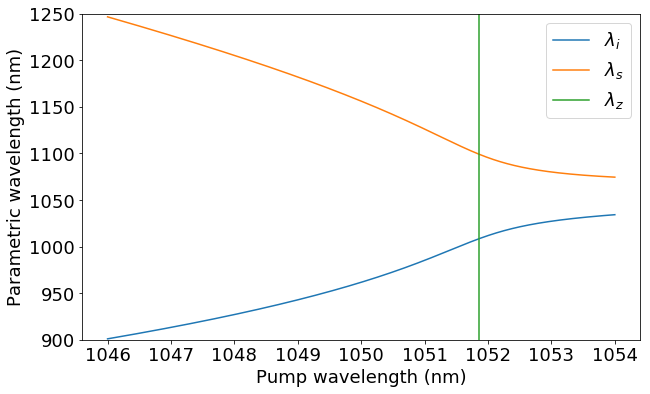

In [84]:
#%matplotlib inline
pump_tot = []
lams_tot = ()
lami_search_vec = [931, 942,919.7,925.3,931.4,940.5,930,940]
lami_search_vec = [1004.5]#1300
#lami_search_vec = [907.071587257, 914.682221613, 917.462384898, 926.920155732, 932.870539474, 944.603966761]
for i, lami_search in enumerate(lami_search_vec):
    sol = fsolve(find_dlami,1050e-9, args = (lami_search*1e-9,lamda0, betas_or))[0]
    pump_tot.append(sol)

    find_dlami(sol,931e-9, lamda0, betas_or)
    ccc = plot(pump_tot[i])[2]
    lams_tot += (ccc,)
#c = plot(sol)[2]
pump_tot = [i * 1e9 for i in pump_tot]

In [85]:
for i in range(len(lams_tot)):
    print(lams_tot[i], pump_tot[i], lami_search_vec[i])


1104.30723779 1051.67962295 1004.5


In [86]:
lam_p_del = [1047.0, 1047.6, 1047.8, 1048.5, 1048.9, 1049.6]

# Finding L1, L2
The attenuation of the system in units of decibels is relates to the transmitence T as:

$$
\alpha_{tot} = -10 \log\left(T\right)
$$
.

Since the splices for PCF is considered to be high two different types of splice losses are assumed. The first $l_1$ is considered the splice loss for the PCF and the second $l_2$ descibes the rest of the losses within the system. 

The total loss in units of dB within our system is found to be:

$$
\alpha_{tot}\left(\lambda\right) = 2 l_{1} + k l_{2} + l_{fibre} - \sum^{N}_{i = 1}10 \log\left(WDM^{(i)}_{p^{(i)}}\left(\lambda\right)\right)
$$
, where $p{(i)}$ is the port that light light is to travel. 


Within the test case $1.4 dB$ loss was quoted within the cavity for a wavelength of $1205nm$ with $1dB$ being given to the loss of the fibre and the PCF losses. 

Since the fibre loss along the length of the fibre is quoted as $a_{L} \cdot L = 0.021dB$ the splice loss can be calculated as

$$
2 \cdot l_{1} + a_{L} \cdot L = 1 \Rightarrow l_{1} = \frac{1 -  a_{L} \cdot L}{2} =  \frac{1 -   0.021}{2} = 0.4895 dB.
$$

Within the cavity the signal is high at the wavelength of: 

Furthermore from this one can consider the second splice loss by taking the loss of the wdm 1, 2 for the signal as:
* port2 of WDM1
* port2 of WDM2

again as above but now with the ring (2 small splices) and the WDM losses with respect to the signal ports. 
The equation to be solved is then:
$$
T(1200) = WDM^{(1)}_{p2}\left(1200 \right) + WDM^{(2)}_{p2}\left(1200 \right) - 2 l_{1} - 3 l_{2} - l_{fibre}
$$


Hence the loss of the second splice can be found by:
$$
l_{2} =  \frac{T(1200) - WDM^{(1)}_{p2}\left(1200 \right) - WDM^{(2)}_{p2}\left(1200 \right) + 2 l_{1} + l_{fibre}}{3}
$$

In [87]:
def dB(x):
    if type(x) is type(1.):
        if x< 1e-16:
            return 0
    #elif type(x) = type(np.array([1])):
    return 10*np.log10(x)

In [88]:
def l2_f(lamda, T, l1):
    num = dB(1/T)  - 2 *l1 - 0.021 + dB(WDM1.il_port2()) +  dB(WDM2.il_port2())
    return num/3

In [89]:
from functions import WDM
lv = np.linspace(850, 1500, 2**14)
fv = 1e-3*c/lv
WDM1 = WDM(1048., 1198.64,fv,c)
WDM2 = WDM(930.998,  1198.64, fv,c)
WDM3 = WDM(930, 1050,fv,c)
WDM4 = WDM(930, 1200,fv,c)
#[1048., 1198.64], 	
#				[930.998,  1198.64]
#WDM1 = WDM(1051.16, 1116.4,fv,c)
#WDM2 = WDM(989.1325877622734, 1116.4, fv,c)
#WDM3 = WDM(989.1325877622734, 1051.16,fv,c)
#WDM4 = WDM(989.1325877622734, 1116.4,fv,c)

In [90]:
def db(x):
    return 10*np.log10(x)

def wdm_losses(l):
    return db(WDM1.il_port2(l)) + db(WDM2.il_port2(l))# + db(WDM3.il_port1(l)) + db(WDM3.il_port1(l))
    

def total_loss(l, l1,l2):
    return  -l1 + wdm_losses(l)# - 0.021

def totalT(l,l1, l2):
    return 10**(total_loss(l,l1,l2)/10)

In [91]:
WDM1.il_port1(1046)*100

99.942898092715453

In [92]:
WDM1.il_port1(1050)*100

99.943332244134254

In [93]:
l1 = 1.4
l2 = 0
#l2 = l2_f(1200, 0.72, l1)
#print('the splice loss of the small loss ones is:', l2, 'dB')

In [94]:
l_p, l_s,l_i  =1048, 1199.32, 930.996

In [95]:
fp = 1e-3*c/1048.17107345

In [96]:
df = 0
fp1 = fp-df
fp2 = fp+df
lp1, lp2 = 1e-3*c/fp1, 1e-3*c/fp2
print(lp1,lp2)
print(totalT(lp1,1.4, 0), totalT(lp2,1.4, 0))

1048.17107345 1048.17107345
1.51038100351e-06 1.51038100351e-06


In [97]:
WDM1 = WDM(l_p, l_s,fv,c)
WDM2 = WDM(l_i, l_s, fv,c)
WDM3 = WDM(l_i, l_p,fv,c)
WDM4 = WDM(l_i, l_s,fv,c)

In [98]:
f_sig = 1e-3 * c/l_s
f_p = 1e-3 * c/l_p
f_c = f_sig - f_p +f_sig
f_i = f_p +f_p -f_sig

In [99]:
fs = 1e-3*c/1200 -1
ls2 = 1e-3*c/fs
print(ls2)

1204.8226268327246


In [100]:
import warnings
warnings.filterwarnings('ignore')

In [101]:
totalT(1237.8226268327246,1.4, 0)

0.62625223070005132

In [102]:
totalT(1141.26,1.4, 0)

0.48500449006537943

In [103]:
totalT(1141.26,1.4, 0)

0.48500449006537943

In [104]:
lams = (1241.09,1199.32,1149.35)
for i in lams:
    print(totalT(i,1.4,0))

0.610569357582
0.724435960075
0.542467561577


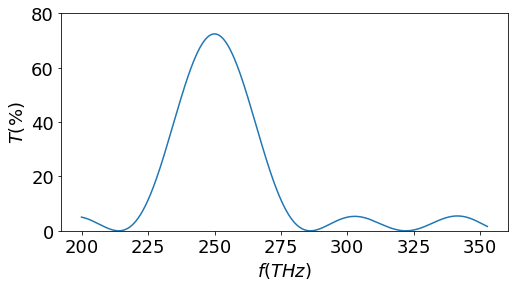

In [105]:
fig = plt.figure(figsize=(8, 4.0))
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(1e-3*c/lv, 100*totalT(lv,l1, l2))
#plt.axvline(f_sig, label = 'Signal',color='b')
#plt.axvline(f_c, label = 'cascade',color='r')
#plt.axvline(f_p, label = 'pump',color='m')
#plt.axvline(f_i, label = 'idler',color='k')
plt.xlabel(r'$f \left(THz \right)$')
#plt.xlim(1050, 1250)
plt.ylim(0,80)
#plt.legend()
plt.ylabel(r'$T \left(\% \right)$')
plt.savefig('stable.png')
#plt.title(['max at', np.max(100*totalT(lv,l1, l2))])
plt.show()

In [106]:
def tick_function(X):
    V = 1e-3*c/X
    return ["%.0f" % z for z in V]

In [119]:
lv_shown = np.array([930,1048,1200,1450])

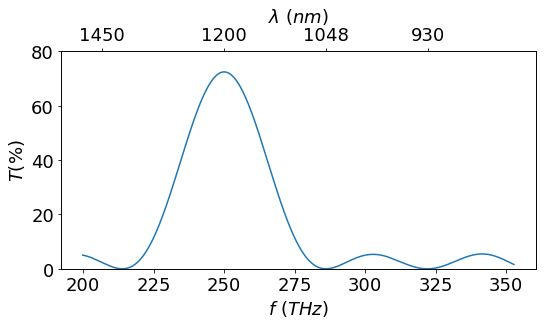

In [120]:
fig = plt.figure(figsize =(8.5,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(1e-3*c/lv, 100*totalT(lv,l1, l2))
ax1.set_xlabel(r'$f$ $\left(THz \right)$')

new_tick_locations = 1e-3*c/lv_shown
ax1.set_ylabel(r'$T \left(\% \right)$')

ax1.set_ylim((0,80))
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"$\lambda$ $\left(n m \right)$")
plt.savefig('Transmitence.pdf', bbox_inches = 'tight')
plt.show()

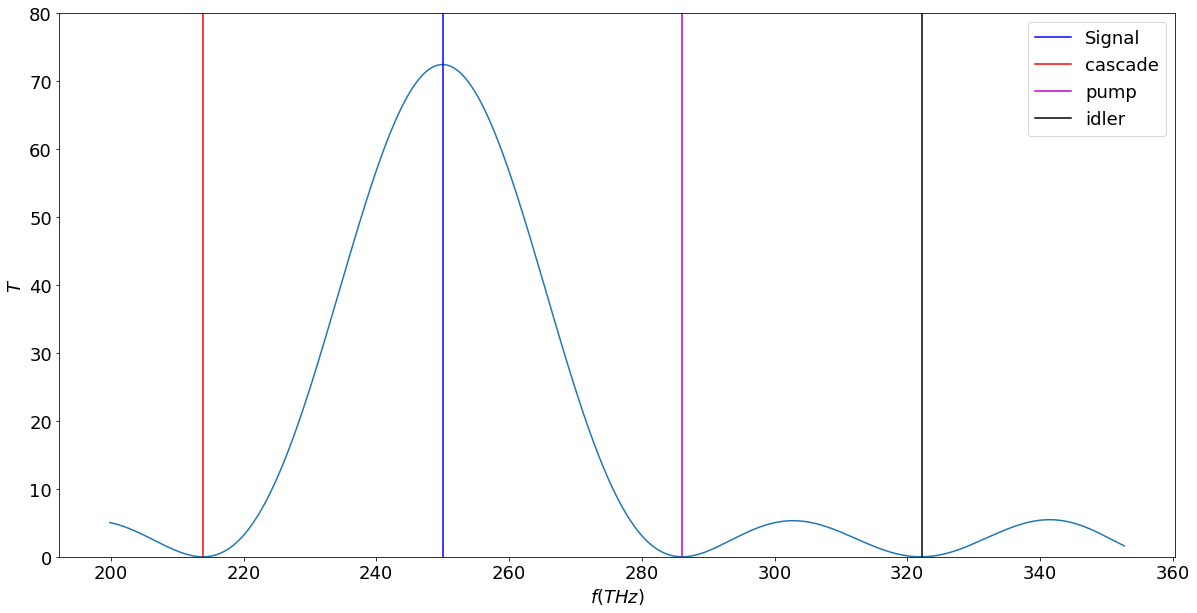

In [109]:
#%matplotlib inline
fig = plt.figure(figsize=(20.0, 10.0))
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(1e-3*c/lv, 100*totalT(lv,l1, l2))
plt.axvline(f_sig, label = 'Signal',color='b')
plt.axvline(f_c, label = 'cascade',color='r')
plt.axvline(f_p, label = 'pump',color='m')
plt.axvline(f_i, label = 'idler',color='k')
plt.xlabel(r'$f(THz)$')
#plt.xlim(1050, 1250)
plt.ylim(0,80)
plt.legend()
plt.ylabel(r'$T$')
plt.savefig('stable.png')
#plt.title(['max at', np.max(100*totalT(lv,l1, l2))])
plt.show()

In [110]:
totalT(1123.97515934,l1,l2)

0.35138676341305108

According to the theory from the FOPO book the theoretical threshold limit is found to be:

In [111]:
from math import acosh
import numpy as np
acosh = np.vectorize(acosh)
def P_th(T, g , L):
    a = (g*L)**(-1)
    b = acosh(np.sqrt(T)**(-1))
    return a*b


In [112]:
pth = P_th(totalT(lv,l1, l2),10e-3, 18)

In [113]:
P_th(totalT(1120,l1, l2),10e-3, 18)

6.5042940024772538

In [114]:
#%matplotlib inline
#fig = plt.figure(figsize=(20,10))
plt.plot(lv, pth)
plt.title([np.min(pth), lv[np.argmin(pth)]])
plt.ylim(0,20)

(0, 20)

In [115]:
from fft_module import *

ModuleNotFoundError: No module named 'fft_module'

In [ ]:
fft,ifft,method = pick(100,2,1000,1)

In [ ]:
N_big = []
t_small = []
t = []
for n in range(1,17):
    N =  2**n
    A = np.random.rand(N) + 1j * np.random.rand(N) 
    for i in range(10000):
        t1 = time()
        A = ifft(A)
        dt = time() - t1
        t_small.append(dt)
    t.append(np.average(t_small))
    N_big.append(N)

In [ ]:
import matplotlib.pyplot as plt
#%matplotlib inline
plt.plot(np.log2(N_big), np.log(np.asanyarray(t)*1e6))
plt.xlabel('log2(Num of points)')
plt.ylabel('time (us)')
plt.title('Intel scipy')
#plt.savefig('intel_scipy.png')

In [ ]:
100*10**(-np.arange(0.5,5.5,1)[::-1]/10)